## Import and install necessary packages¶

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import calendar
import scipy

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
conda install tqdm

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

## Get merged and cleaned data

In [4]:
df = pd.read_csv('games_clean_df.csv')
df.head(10)

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,metascore,userscore,date
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,0.99,3.12,2013,97,8.3,"Sep 17, 2013"
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,0.60,3.02,2014,97,8.3,"Nov 18, 2014"
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,0.47,1.78,2002,95,8.8,"Oct 27, 2002"
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,0.06,1.42,2013,97,8.3,"Sep 17, 2013"
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,0.13,1.33,2011,88,3.4,"Nov 08, 2011"
5,42,Call of Duty: Black Ops,Shooter,M,X360,Activision,Treyarch,14.74,9.76,3.73,0.11,1.14,2010,87,6.4,"Nov 09, 2010"
6,46,Red Dead Redemption 2,Action-Adventure,M,PS4,Rockstar Games,Rockstar Games,13.94,5.26,6.21,0.21,2.26,2018,97,7.7,"Oct 26, 2018"
7,47,Call of Duty: Black Ops II,Shooter,M,X360,Activision,Treyarch,13.86,8.27,4.32,0.07,1.20,2012,83,5.0,"Nov 13, 2012"
8,48,Call of Duty: Black Ops II,Shooter,M,PS3,Activision,Treyarch,13.80,4.99,5.88,0.65,2.28,2012,83,5.4,"Nov 13, 2012"
9,50,Call of Duty: Modern Warfare 2,Shooter,M,X360,Activision,Infinity Ward,13.53,8.54,3.63,0.08,1.28,2009,94,6.4,"Nov 10, 2009"


In [5]:
# new column for years ago
df['years_ago'] = 2020 - df['date'].str[-4:].astype(int)
# take first 3 characters of date for month abbreviation
df['month_abbrev'] = df['date'].str[:3]
def month_numerize(abbrev):
    for k, v in enumerate(calendar.month_abbr):
        if abbrev == v:
            return k
        
# column for numerical representations of month (Jan is 01, Feb is 02, etc.)
df['month_num'] = df['month_abbrev'].apply(month_numerize)
# months ago from April 2020
df['months_ago'] = (df['years_ago'] * 12) + (12 - df['month_num']) + 4 - 12
# dummy categories for months, haven't put this into the dataframe yet
month_dummies = pd.get_dummies(df['month_abbrev'], drop_first=True)

In [6]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,metascore,userscore,date,years_ago,month_abbrev,month_num,months_ago
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,0.99,3.12,2013,97,8.3,"Sep 17, 2013",7,Sep,9,79
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,0.60,3.02,2014,97,8.3,"Nov 18, 2014",6,Nov,11,65
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,0.47,1.78,2002,95,8.8,"Oct 27, 2002",18,Oct,10,210
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,0.06,1.42,2013,97,8.3,"Sep 17, 2013",7,Sep,9,79
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,0.13,1.33,2011,88,3.4,"Nov 08, 2011",9,Nov,11,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Paradox Interactive,Paradox Interactive,0.01,NaN,0.01,NaN,0.00,2007,83,8.4,"Jan 23, 2007",13,Jan,1,159
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Deep Red Games,0.01,NaN,0.01,NaN,0.00,2001,85,7.7,"Sep 24, 2001",19,Sep,9,223
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.01,NaN,0.01,NaN,0.00,2003,91,8.5,"Oct 29, 2003",17,Oct,10,198
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Blue Byte Software / Related Designs,0.01,NaN,0.00,NaN,0.00,2010,78,7.9,"Feb 26, 2010",10,Feb,2,122


In [7]:
consoles = {
    'N64': {'Company': 'Nintendo', 'Family': 'Nintendo', 'Launch': 285, 'Successor': 'GC', 'Units Sold': 32.4},
    'GC': {'Company': 'Nintendo', 'Family': 'Nintendo', 'Launch': 222, 'Successor': 'WII', 'Units Sold': 21.7},
    'WII': {'Company': 'Nintendo', 'Family': 'Nintendo', 'Launch': 160, 'Successor': 'WIIU', 'Units Sold': 101.6},
    'WIIU': {'Company': 'Nintendo', 'Family': 'Nintendo', 'Launch': 88, 'Successor': 'Switch', 'Units Sold': 13.6},
    'Switch': {'Company': 'Nintendo', 'Family': 'Nintendo', 'Launch': 36, 'Successor': 'current', 'Units Sold': 52.5},
    'PS': {'Company': 'Sony', 'Family': 'Sony', 'Launch': 303, 'Successor': 'PS2', 'Units Sold': 102.5},
    'PS2': {'Company': 'Sony', 'Family': 'Sony', 'Launch': 240, 'Successor': 'PS3', 'Units Sold': 155},
    'PS3': {'Company': 'Sony', 'Family': 'Sony', 'Launch': 160, 'Successor': 'PS4', 'Units Sold': 87.4},
    'PS4': {'Company': 'Sony', 'Family': 'Sony', 'Launch': 77, 'Successor': 'PS5', 'Units Sold': 108.9},
    'PS5': {'Company': 'Sony', 'Family': 'Sony', 'Launch': -7, 'Successor': 'current', 'Units Sold': 'None'},
    'XBOX': {'Company': 'Microsoft', 'Family': 'Microsoft', 'Launch': 220, 'Successor': 'X360', 'Units Sold': 24},
    'X360': {'Company': 'Microsoft', 'Family': 'Microsoft', 'Launch': 172, 'Successor': 'XONE', 'Units Sold': 84},
    'XONE': {'Company': 'Microsoft', 'Family': 'Microsoft', 'Launch': 77, 'Successor': 'XBS', 'Units Sold': 46.9},
    'XBS': {'Company': 'Microsoft', 'Family': 'Microsoft', 'Launch': -7, 'Successor': 'current', 'Units Sold': 0},
    'GBA': {'Company': 'Nintendo', 'Family': 'Nintendo_Handheld', 'Launch': 228, 'Successor': 'DS', 'Units Sold': 85.1},
    'DS': {'Company': 'Nintendo', 'Family': 'Nintendo_Handheld', 'Launch': 184, 'Successor': '3DS', 'Units Sold': 154},
    '3DS': {'Company': 'Nintendo', 'Family': 'Nintendo_Handheld', 'Launch': 109, 'Successor': 'current', 'Units Sold': 75.7},
    'PSP': {'Company': 'Sony', 'Family': 'Sony_Handheld', 'Launch': 183, 'Successor': 'VITA', 'Units Sold': 80},
    'VITA': {'Company': 'Sony', 'Family': 'Sony_Handheld', 'Launch': 99, 'Successor': 'current', 'Units Sold': 10},
    'DC': {'Company': 'Sega', 'Family': 'Sega', 'Launch': 256, 'Successor': 'current', 'Units Sold': 9},
    'PC': {'Company': 'PC', 'Family': 'PC', 'Launch': 0, 'Successor': 'current', 'Units Sold': 100},
}

In [8]:
consoles['N64']['Units Sold']

32.4

In [9]:
for index, row in df.iterrows():
    company = consoles[row['Platform']]['Company']
    df.at[index, 'Company'] = company

In [10]:
for index, row in df.iterrows():
    units = consoles[row['Platform']]['Units Sold']
    df.at[index, 'Units_Sold'] = units

In [11]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,...,Year,metascore,userscore,date,years_ago,month_abbrev,month_num,months_ago,Company,Units_Sold
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,...,2013,97,8.3,"Sep 17, 2013",7,Sep,9,79,Sony,87.4
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,...,2014,97,8.3,"Nov 18, 2014",6,Nov,11,65,Sony,108.9
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,...,2002,95,8.8,"Oct 27, 2002",18,Oct,10,210,Sony,155.0
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,...,2013,97,8.3,"Sep 17, 2013",7,Sep,9,79,Microsoft,84.0
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,...,2011,88,3.4,"Nov 08, 2011",9,Nov,11,101,Microsoft,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Paradox Interactive,Paradox Interactive,0.01,NaN,0.01,...,2007,83,8.4,"Jan 23, 2007",13,Jan,1,159,PC,100.0
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Deep Red Games,0.01,NaN,0.01,...,2001,85,7.7,"Sep 24, 2001",19,Sep,9,223,PC,100.0
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.01,NaN,0.01,...,2003,91,8.5,"Oct 29, 2003",17,Oct,10,198,PC,100.0
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Blue Byte Software / Related Designs,0.01,NaN,0.00,...,2010,78,7.9,"Feb 26, 2010",10,Feb,2,122,PC,100.0


In [12]:
# return a percentage of when a game was released in a console's lifespan

# GTAV (PS3) was released right before the PS4 launched, so it has a 98% value
# God of War 2 (PS2) was released after the PS3 launched, so it has a value over 100%
# (game_release - console_launch) / (console_launch - successor_launch)
def generation_lifespan(console, months_ago):
    successor = consoles[console]['Successor']
    if successor == 'current':
        return successor
    else:
        successor_launch = consoles[successor]['Launch']
        console_launch = consoles[console]['Launch']
        return abs((months_ago - console_launch) / (console_launch - successor_launch))

In [13]:
df['generation_lifespan'] = df.apply(lambda x: generation_lifespan(x['Platform'], x['months_ago']), axis=1)

In [14]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,...,metascore,userscore,date,years_ago,month_abbrev,month_num,months_ago,Company,Units_Sold,generation_lifespan
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,...,97,8.3,"Sep 17, 2013",7,Sep,9,79,Sony,87.4,0.975904
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,...,97,8.3,"Nov 18, 2014",6,Nov,11,65,Sony,108.9,0.142857
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,...,95,8.8,"Oct 27, 2002",18,Oct,10,210,Sony,155.0,0.375
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,...,97,8.3,"Sep 17, 2013",7,Sep,9,79,Microsoft,84.0,0.978947
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,...,88,3.4,"Nov 08, 2011",9,Nov,11,101,Microsoft,84.0,0.747368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Paradox Interactive,Paradox Interactive,0.01,NaN,0.01,...,83,8.4,"Jan 23, 2007",13,Jan,1,159,PC,100.0,current
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Deep Red Games,0.01,NaN,0.01,...,85,7.7,"Sep 24, 2001",19,Sep,9,223,PC,100.0,current
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.01,NaN,0.01,...,91,8.5,"Oct 29, 2003",17,Oct,10,198,PC,100.0,current
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Blue Byte Software / Related Designs,0.01,NaN,0.00,...,78,7.9,"Feb 26, 2010",10,Feb,2,122,PC,100.0,current


In [15]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,...,metascore,userscore,date,years_ago,month_abbrev,month_num,months_ago,Company,Units_Sold,generation_lifespan
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,...,97,8.3,"Sep 17, 2013",7,Sep,9,79,Sony,87.4,0.975904
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,...,97,8.3,"Nov 18, 2014",6,Nov,11,65,Sony,108.9,0.142857
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,...,95,8.8,"Oct 27, 2002",18,Oct,10,210,Sony,155.0,0.375
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,...,97,8.3,"Sep 17, 2013",7,Sep,9,79,Microsoft,84.0,0.978947
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,...,88,3.4,"Nov 08, 2011",9,Nov,11,101,Microsoft,84.0,0.747368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Paradox Interactive,Paradox Interactive,0.01,NaN,0.01,...,83,8.4,"Jan 23, 2007",13,Jan,1,159,PC,100.0,current
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Deep Red Games,0.01,NaN,0.01,...,85,7.7,"Sep 24, 2001",19,Sep,9,223,PC,100.0,current
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.01,NaN,0.01,...,91,8.5,"Oct 29, 2003",17,Oct,10,198,PC,100.0,current
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Blue Byte Software / Related Designs,0.01,NaN,0.00,...,78,7.9,"Feb 26, 2010",10,Feb,2,122,PC,100.0,current


In [16]:
for index, row in df.iterrows():
    if row["generation_lifespan"] == "current":
        df.at[index, 'generation_flag'] = 1
    else:
        df.at[index, 'generation_flag'] = 0

df.loc[(df["generation_lifespan"] == 'current'),'generation_lifespan']=np.NaN

imr = SimpleImputer(missing_values=np.NaN, strategy='mean')
imr = imr.fit(df[['generation_lifespan']])
df['generation_lifespan'] = imr.transform(df[['generation_lifespan']]).ravel()

In [17]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,...,userscore,date,years_ago,month_abbrev,month_num,months_ago,Company,Units_Sold,generation_lifespan,generation_flag
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,...,8.3,"Sep 17, 2013",7,Sep,9,79,Sony,87.4,0.975904,0.0
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,...,8.3,"Nov 18, 2014",6,Nov,11,65,Sony,108.9,0.142857,0.0
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,...,8.8,"Oct 27, 2002",18,Oct,10,210,Sony,155.0,0.375000,0.0
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,...,8.3,"Sep 17, 2013",7,Sep,9,79,Microsoft,84.0,0.978947,0.0
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,...,3.4,"Nov 08, 2011",9,Nov,11,101,Microsoft,84.0,0.747368,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Paradox Interactive,Paradox Interactive,0.01,NaN,0.01,...,8.4,"Jan 23, 2007",13,Jan,1,159,PC,100.0,0.516602,1.0
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Deep Red Games,0.01,NaN,0.01,...,7.7,"Sep 24, 2001",19,Sep,9,223,PC,100.0,0.516602,1.0
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.01,NaN,0.01,...,8.5,"Oct 29, 2003",17,Oct,10,198,PC,100.0,0.516602,1.0
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Blue Byte Software / Related Designs,0.01,NaN,0.00,...,7.9,"Feb 26, 2010",10,Feb,2,122,PC,100.0,0.516602,1.0


In [18]:
for index, row in df.iterrows():
    if df[df["Publisher"] == row["Publisher"]].shape[0] < 25:
        df.at[index, 'Publisher'] = 'Others'
    else:
        pass

In [19]:
df['Publisher'].value_counts()

Others                                    922
Electronic Arts                           459
Activision                                412
Ubisoft                                   393
EA Sports                                 342
Sega                                      274
THQ                                       243
Sony Computer Entertainment               242
Konami                                    206
Capcom                                    206
Nintendo                                  169
Atlus                                     131
Atari                                     125
Eidos Interactive                         110
Square Enix                               104
Midway Games                              104
Namco Bandai                               96
2K Sports                                  94
Codemasters                                94
NIS America                                84
LucasArts                                  84
Namco                             

In [20]:
for index, row in df.iterrows():
    if df[df["Developer"] == row["Developer"]].shape[0] < 20:
        df.at[index, 'Developer'] = 'Others'
    else:
        pass

In [21]:
df['Developer'].value_counts()

Others                            4180
EA Canada                          191
EA Tiburon                         142
Capcom                             117
Ubisoft Montreal                   101
Konami                              86
Traveller's Tales                   81
Visual Concepts                     79
Omega Force                         76
Vicarious Visions                   47
Ubisoft                             45
EA Redwood Shores                   42
Maxis                               42
Square Enix                         41
Neversoft Entertainment             40
Codemasters                         39
Treyarch                            38
Eurocom Entertainment Software      38
Namco                               38
EA Black Box                        36
From Software                       35
Arc System Works                    34
Sonic Team                          32
EA Sports                           32
Nippon Ichi Software                31
Harmonix Music Systems   

In [22]:
for index, row in df.iterrows():
    if df[df["Genre"] == row["Genre"]].shape[0] < 100:
        df.at[index, 'Genre'] = 'Others'
    else:
        pass

In [23]:
df['Genre'].value_counts()

Action              1157
Sports               905
Shooter              812
Role-Playing         652
Racing               490
Platform             372
Adventure            370
Fighting             335
Misc                 305
Simulation           267
Strategy             261
Puzzle               132
Action-Adventure     113
Others                71
Name: Genre, dtype: int64

In [24]:
for index, row in tqdm(df.iterrows()):
    mean = df[df["Publisher"] == row["Publisher"]].mean()['metascore']
    df.at[index, 'Publisher_Metascore'] = mean

In [25]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,...,date,years_ago,month_abbrev,month_num,months_ago,Company,Units_Sold,generation_lifespan,generation_flag,Publisher_Metascore
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Others,20.32,6.37,9.85,...,"Sep 17, 2013",7,Sep,9,79,Sony,87.4,0.975904,0.0,82.900000
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Others,19.39,6.06,9.71,...,"Nov 18, 2014",6,Nov,11,65,Sony,108.9,0.142857,0.0,82.900000
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Others,16.15,8.41,5.49,...,"Oct 27, 2002",18,Oct,10,210,Sony,155.0,0.375000,0.0,82.900000
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Others,15.86,9.06,5.33,...,"Sep 17, 2013",7,Sep,9,79,Microsoft,84.0,0.978947,0.0,82.900000
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.82,9.07,4.29,...,"Nov 08, 2011",9,Nov,11,101,Microsoft,84.0,0.747368,0.0,70.563107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Others,Others,0.01,NaN,0.01,...,"Jan 23, 2007",13,Jan,1,159,PC,100.0,0.516602,1.0,66.074837
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Others,0.01,NaN,0.01,...,"Sep 24, 2001",19,Sep,9,223,PC,100.0,0.516602,1.0,67.160000
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.01,NaN,0.01,...,"Oct 29, 2003",17,Oct,10,198,PC,100.0,0.516602,1.0,70.563107
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Others,0.01,NaN,0.00,...,"Feb 26, 2010",10,Feb,2,122,PC,100.0,0.516602,1.0,69.944020


In [26]:
for index, row in tqdm(df.iterrows()):
    mean = df[df["Publisher"] == row["Publisher"]].mean()['userscore']
    df.at[index, 'Publisher_Userscore'] = mean

In [27]:
for index, row in tqdm(df.iterrows()):
    mean = df[df["Developer"] == row["Developer"]].mean()['metascore']
    df.at[index, 'Developer_Metascore'] = mean

In [28]:
for index, row in tqdm(df.iterrows()):
    mean = df[df["Developer"] == row["Developer"]].mean()['userscore']
    df.at[index, 'Developer_Userscore'] = mean

In [29]:
for index, row in tqdm(df.iterrows()):
    mean = df[df["Genre"] == row["Genre"]].mean()['metascore']
    df.at[index, 'Genre_Metascore'] = mean

In [30]:
for index, row in tqdm(df.iterrows()):
    mean = df[df["Genre"] == row["Genre"]].mean()['userscore']
    df.at[index, 'Genre_Userscore'] = mean

In [31]:
df['Developer'].value_counts()

Others                            4180
EA Canada                          191
EA Tiburon                         142
Capcom                             117
Ubisoft Montreal                   101
Konami                              86
Traveller's Tales                   81
Visual Concepts                     79
Omega Force                         76
Vicarious Visions                   47
Ubisoft                             45
EA Redwood Shores                   42
Maxis                               42
Square Enix                         41
Neversoft Entertainment             40
Codemasters                         39
Treyarch                            38
Eurocom Entertainment Software      38
Namco                               38
EA Black Box                        36
From Software                       35
Arc System Works                    34
Sonic Team                          32
EA Sports                           32
Nippon Ichi Software                31
Harmonix Music Systems   

In [32]:
df.to_csv("games_df.csv")

In [33]:
df[df["Publisher"] == "Electronic Arts"].mean()['metascore']

73.6557734204793

## EDA

### General

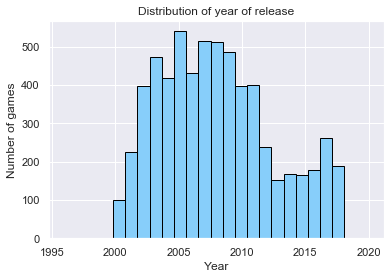

In [34]:
num_years = df["Year"].max() - df["Year"].min() + 1
plt.hist(df["Year"], bins=num_years, color="lightskyblue", edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year")
plt.ylabel("Number of games");

In [35]:
df.columns

Index(['Rank', 'Name', 'Genre', 'ESRB_Rating', 'Platform', 'Publisher',
       'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales',
       'Other_Sales', 'Year', 'metascore', 'userscore', 'date', 'years_ago',
       'month_abbrev', 'month_num', 'months_ago', 'Company', 'Units_Sold',
       'generation_lifespan', 'generation_flag', 'Publisher_Metascore',
       'Publisher_Userscore', 'Developer_Metascore', 'Developer_Userscore',
       'Genre_Metascore', 'Genre_Userscore'],
      dtype='object')

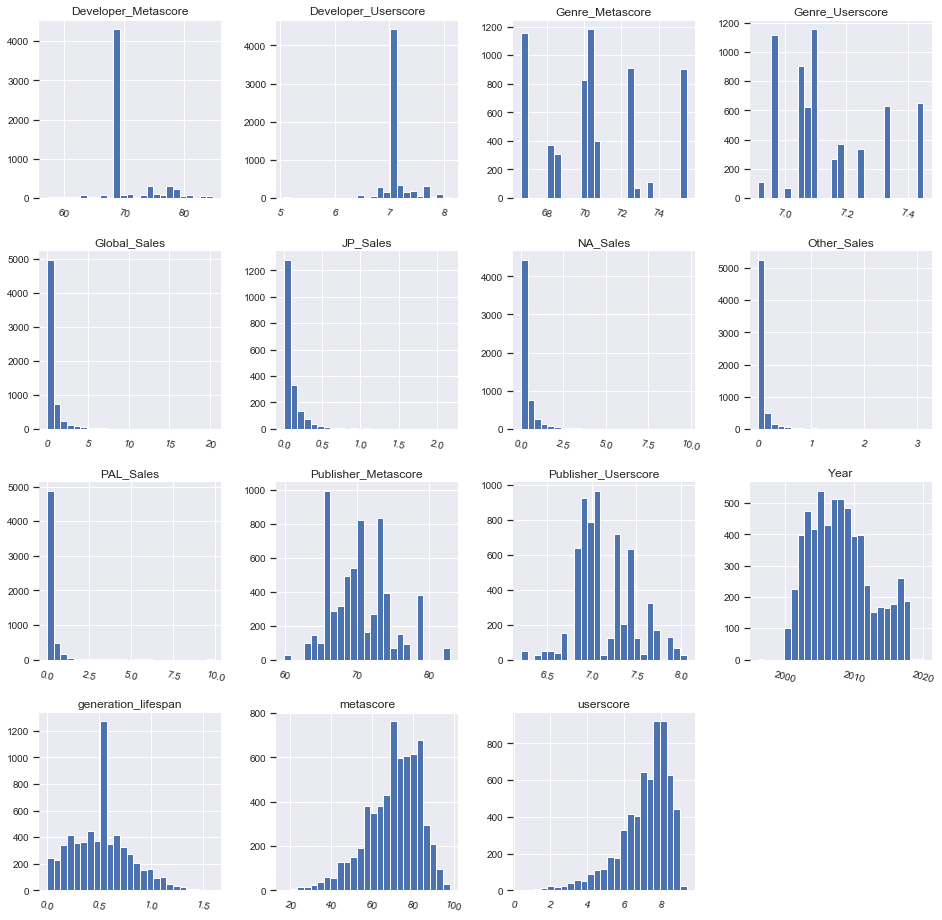

In [36]:
df1=df[['Genre', 'ESRB_Rating', 'Platform', 'Publisher',
    'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales',
    'metascore', 'userscore', 'Year', 'Company', 'generation_lifespan', 'Publisher_Metascore',
       'Publisher_Userscore', 'Developer_Metascore', 'Developer_Userscore',
       'Genre_Metascore', 'Genre_Userscore']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [37]:
df2 = df[['Genre', 'ESRB_Rating', 'Platform', 'Publisher',
    'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales',
    'metascore', 'userscore', 'Year', 'Company', 'generation_lifespan', 'Publisher_Metascore',
       'Publisher_Userscore', 'Developer_Metascore', 'Developer_Userscore',
       'Genre_Metascore', 'Genre_Userscore']]
df2.corr()

,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,metascore,userscore,Year,generation_lifespan,Publisher_Metascore,Publisher_Userscore,Developer_Metascore,Developer_Userscore,Genre_Metascore,Genre_Userscore
Global_Sales,1.000000,0.916924,0.909778,0.236448,0.892993,0.308538,0.043450,0.063246,-0.011980,0.237175,0.028047,0.174381,-0.107094,0.025235,-0.101222
NA_Sales,0.916924,1.000000,0.690198,0.097025,0.733107,0.322977,0.058544,0.022769,-0.019029,0.240616,0.002228,0.198188,-0.139179,0.032187,-0.107425
PAL_Sales,0.909778,0.690198,1.000000,0.178308,0.844323,0.258746,-0.001762,0.135632,-0.014966,0.200015,0.011091,0.135898,-0.080799,0.023488,-0.093647
JP_Sales,0.236448,0.097025,0.178308,1.000000,0.237573,0.142650,0.162321,-0.117656,0.096096,0.015858,0.216487,-0.039099,0.096536,0.030607,0.114628
Other_Sales,0.892993,0.733107,0.844323,0.237573,1.000000,0.262991,0.025308,0.101043,0.009644,0.213741,0.027140,0.147285,-0.097010,0.026697,-0.103551
metascore,0.308538,0.322977,0.258746,0.142650,0.262991,1.000000,0.543455,0.030256,-0.002831,0.316887,0.101921,0.311176,0.056809,0.213279,0.021206
userscore,0.043450,0.058544,-0.001762,0.162321,0.025308,0.543455,1.000000,-0.231815,0.036689,0.076095,0.236591,0.033003,0.180775,0.010857,0.109195
Year,0.063246,0.022769,0.135632,-0.117656,0.101043,0.030256,-0.231815,1.000000,0.098059,-0.012993,-0.194570,-0.033616,-0.050641,-0.020345,0.000897
generation_lifespan,-0.011980,-0.019029,-0.014966,0.096096,0.009644,-0.002831,0.036689,0.098059,1.000000,-0.014686,0.016699,-0.054124,0.000652,-0.052457,0.086803
Publisher_Metascore,0.237175,0.240616,0.200015,0.015858,0.213741,0.316887,0.076095,-0.012993,-0.014686,1.000000,0.321632,0.353551,-0.047053,0.294556,-0.112050


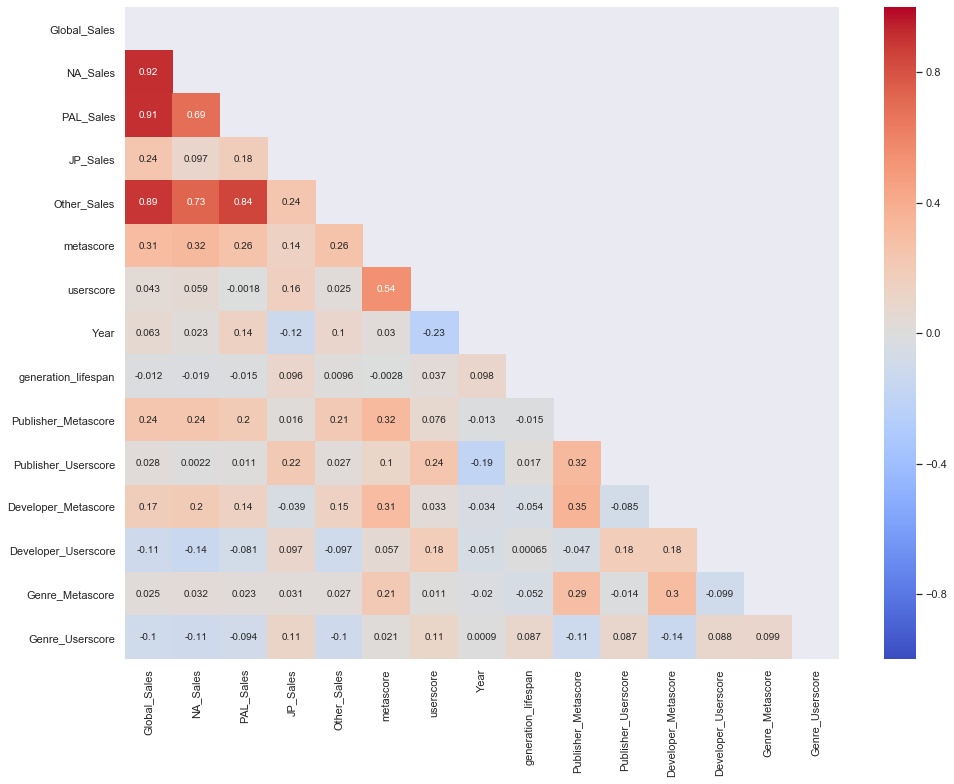

In [38]:
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(df2.corr())
sns.heatmap(df2.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

### Video Game Genres

In [39]:
genre_df = df.groupby('Genre', as_index=False).agg({'Global_Sales': ['sum','count']})
genre_df.columns = genre_df.columns.droplevel(0)
genre_df.reset_index()

,index,,sum,count
0,0,Action,770.87,1157
1,1,Action-Adventure,114.04,113
2,2,Adventure,153.63,370
3,3,Fighting,182.54,335
4,4,Misc,211.59,305
5,5,Others,36.09,71
6,6,Platform,212.42,372
7,7,Puzzle,41.80,132
8,8,Racing,283.65,490
9,9,Role-Playing,328.56,652


In [40]:
genre_df.columns = ['Genre', 'Sum', 'Count']
genre_df = genre_df.sort_values("Count", ascending=False)

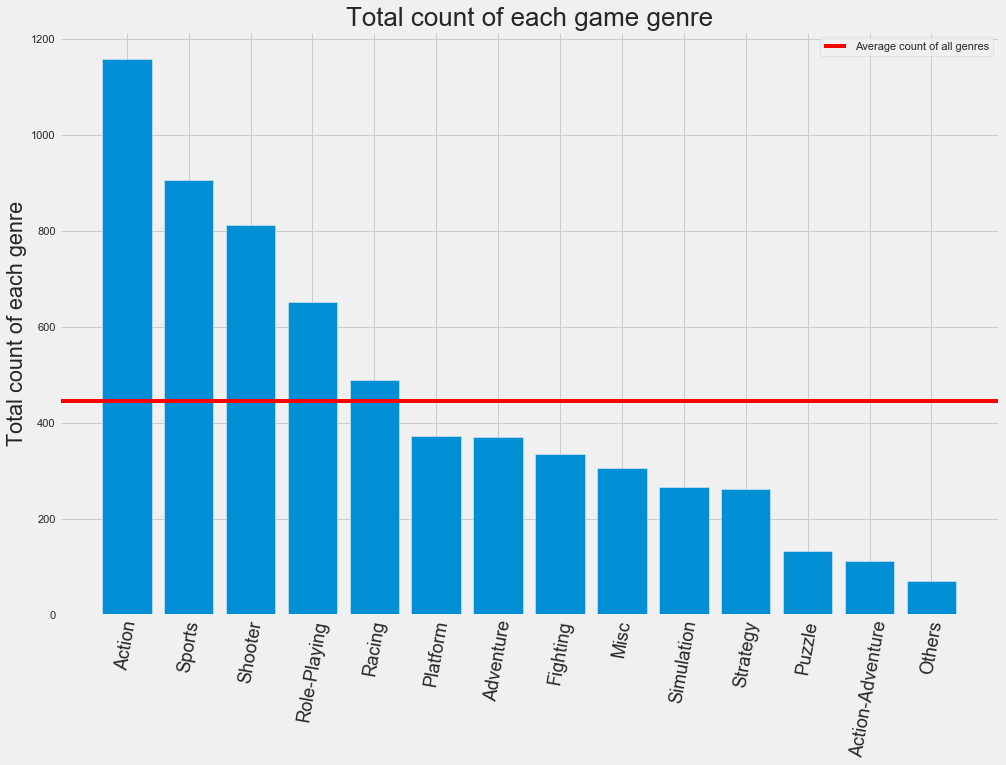

In [41]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genre_df["Genre"],genre_df["Count"])
ax.axhline(genre_df["Count"].mean(), color="red", label="Average count of all genres")

ax.set_xticklabels(genre_df["Genre"], rotation=80, fontsize=18)

ax.set_ylabel("Total count of each genre")
ax.set_title('Total count of each game genre')
ax.legend()

plt.show()

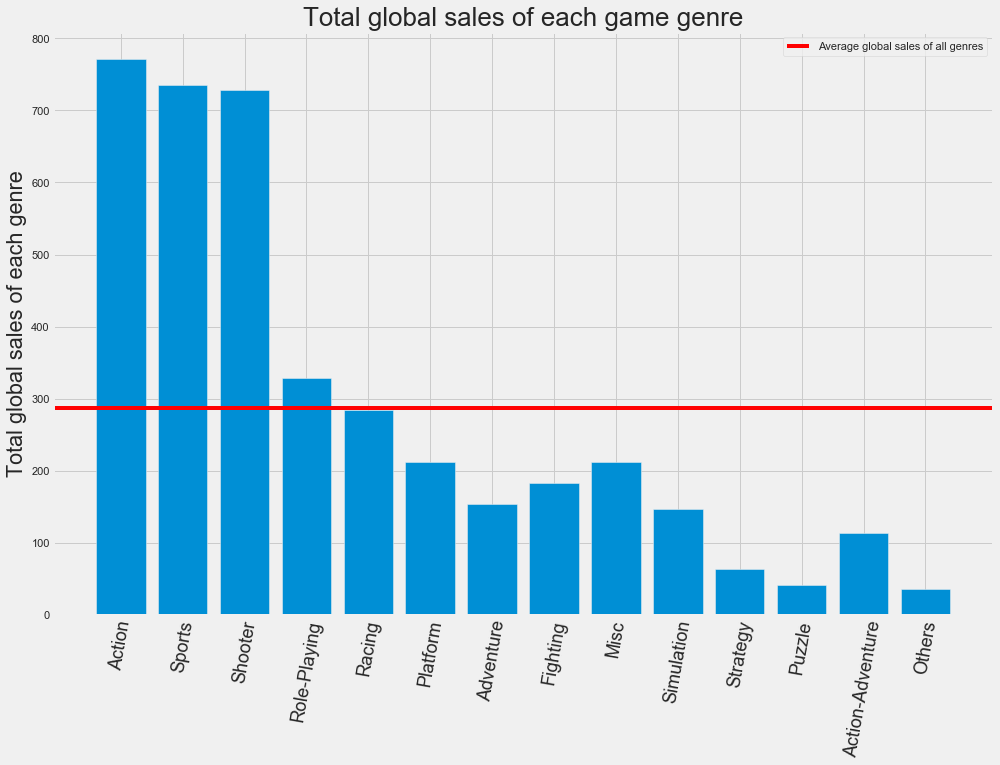

In [42]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genre_df["Genre"],genre_df["Sum"])
ax.axhline(genre_df["Sum"].mean(), color="red", label="Average global sales of all genres")

ax.set_xticklabels(genre_df["Genre"], rotation=80, fontsize=18)

ax.set_ylabel("Total global sales of each genre")
ax.set_title('Total global sales of each game genre')
ax.legend()

plt.show()

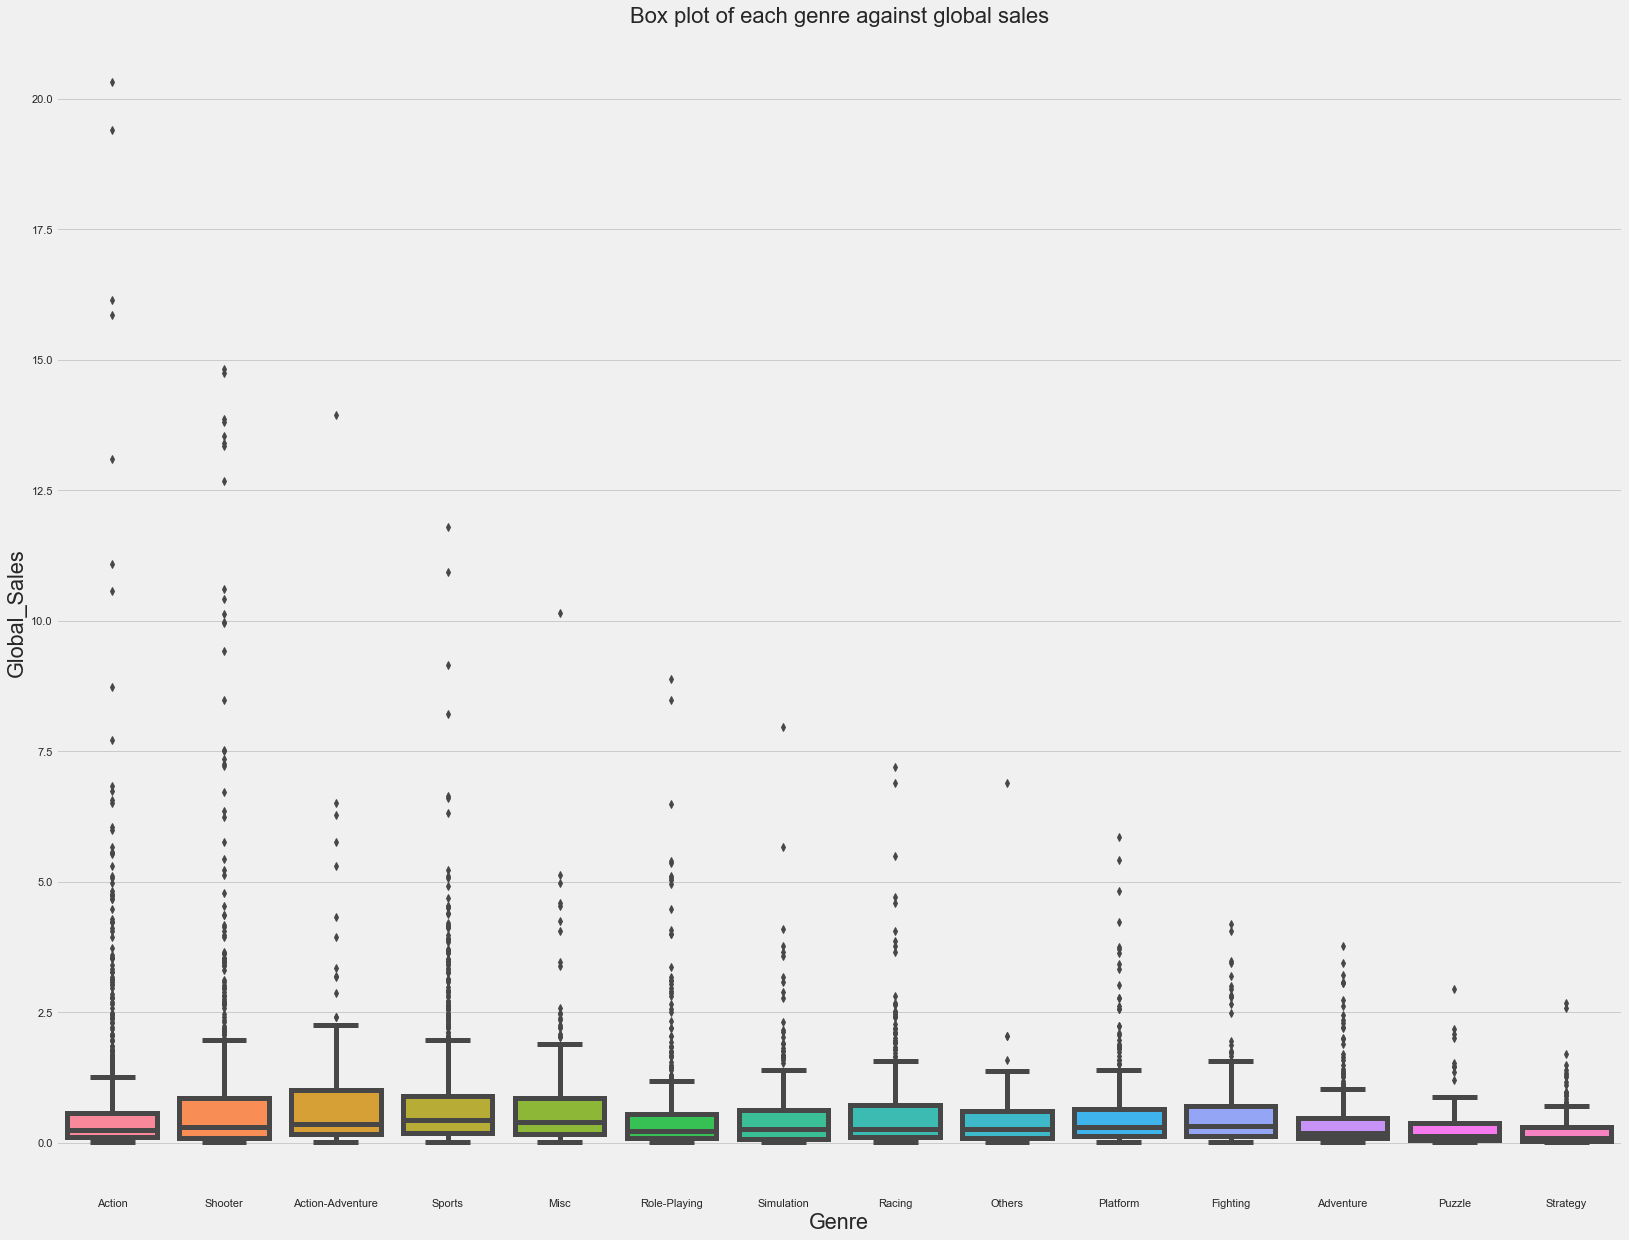

In [43]:
fig, ax = plt.subplots(figsize=(25,20))
plt.rcParams.update({'font.size': 18})
ax = sns.boxplot(x=df['Genre'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each genre against global sales', fontsize= 22)
ax

### Video Game Platforms

In [44]:
platform_df = df.groupby('Platform', as_index=False).agg({'Global_Sales': ['sum','count']})
platform_df.columns = platform_df.columns.droplevel(0)
platform_df.reset_index()

,index,,sum,count
0,0,3DS,51.46,146
1,1,DC,3.02,12
2,2,DS,155.13,388
3,3,GBA,93.55,215
4,4,GC,88.37,312
5,5,N64,8.98,17
6,6,PC,118.71,490
7,7,PS,59.94,78
8,8,PS2,768.32,1041
9,9,PS3,694.17,653


In [45]:
platform_df.columns = ['Platform', 'Sum', 'Count']
platform_df = platform_df.sort_values("Count", ascending=False)
platform_df

,Platform,Sum,Count
8,PS2,768.32,1041
16,X360,723.86,753
9,PS3,694.17,653
17,XBOX,176.61,540
6,PC,118.71,490
10,PS4,402.41,400
14,WII,251.69,394
2,DS,155.13,388
11,PSP,154.98,343
4,GC,88.37,312


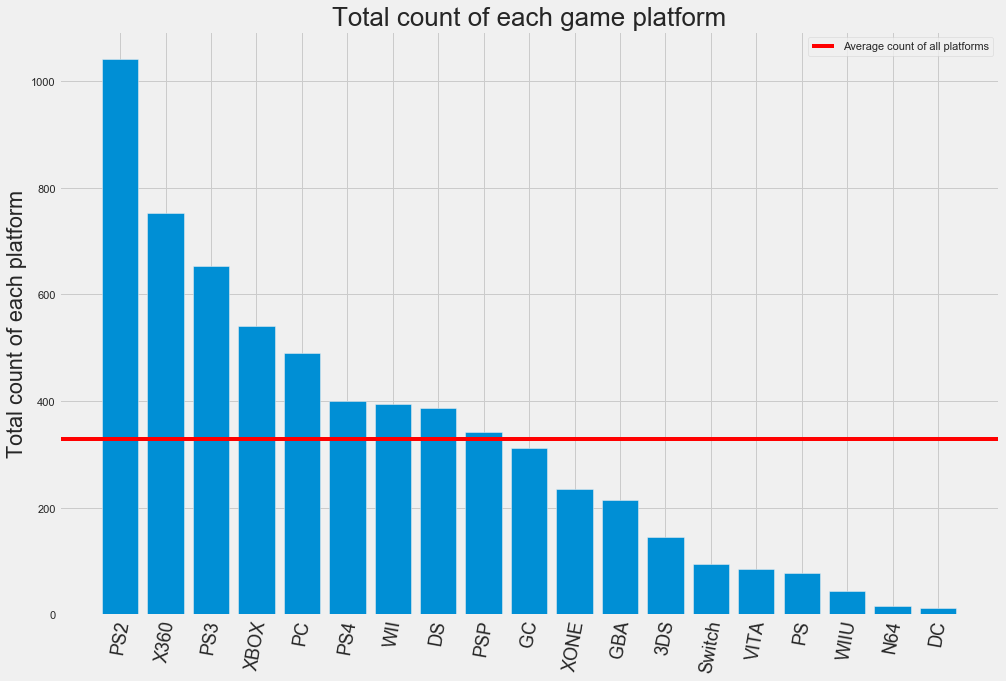

In [46]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(platform_df["Platform"],platform_df["Count"])
ax.axhline(platform_df["Count"].mean(), color="red", label="Average count of all platforms")

ax.set_xticklabels(platform_df["Platform"], rotation=80, fontsize=18)

ax.set_ylabel("Total count of each platform")
ax.set_title('Total count of each game platform')
ax.legend()

plt.show()

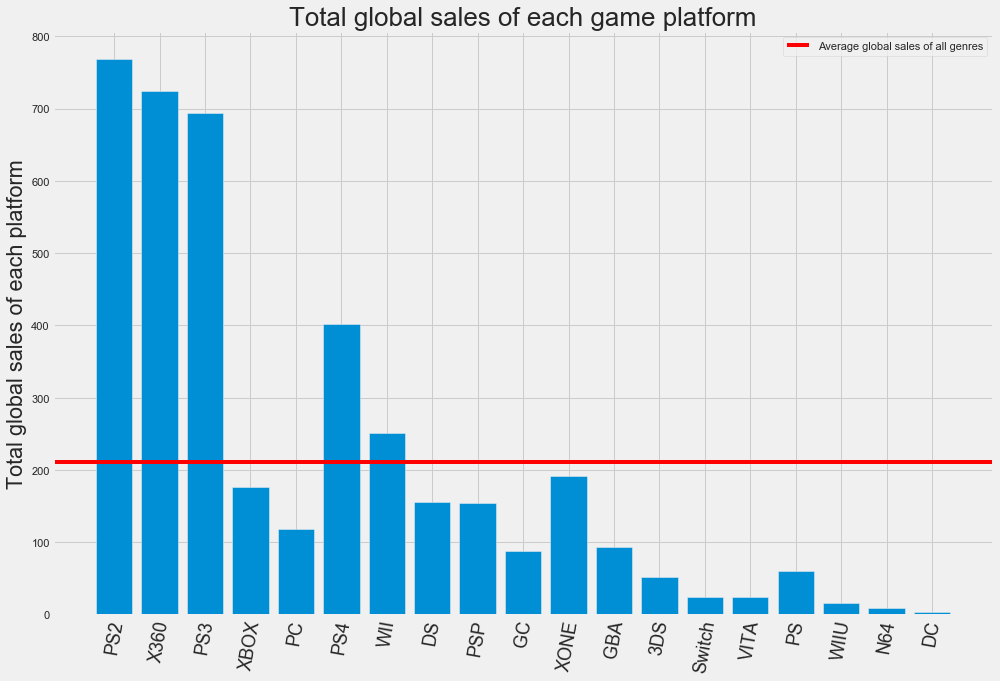

In [47]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(platform_df["Platform"],platform_df["Sum"])
ax.axhline(platform_df["Sum"].mean(), color="red", label="Average global sales of all genres")

ax.set_xticklabels(platform_df["Platform"], rotation=80, fontsize = 18)

ax.set_ylabel("Total global sales of each platform")
ax.set_title('Total global sales of each game platform')
ax.legend()

plt.show()

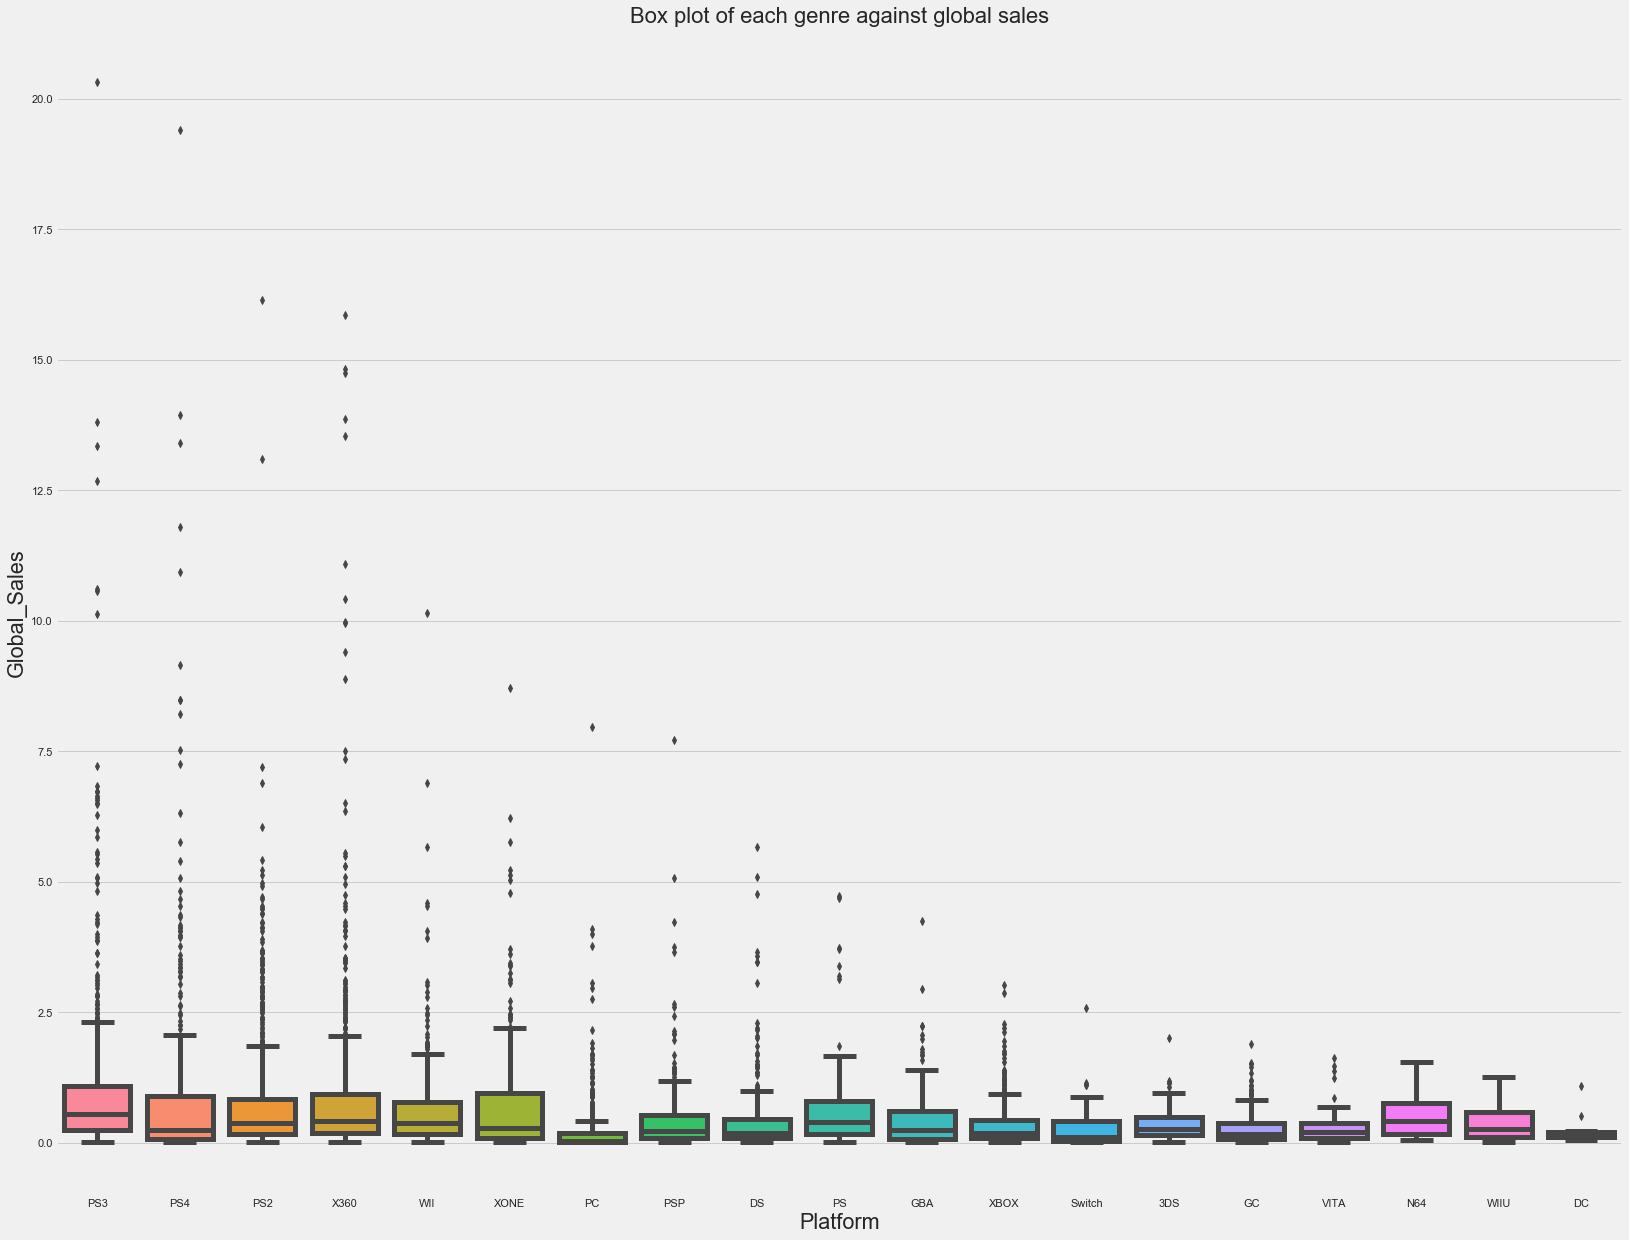

In [48]:
fig, ax = plt.subplots(figsize=(25,20))
plt.rcParams.update({'font.size': 18})
ax = sns.boxplot(x=df['Platform'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each genre against global sales', fontsize= 22)
ax

### Video Game Platform Companies

In [49]:
company_df = df.groupby('Company', as_index=False).agg({'Global_Sales': ['sum','count']})
company_df.columns = company_df.columns.droplevel(0)
company_df.reset_index()

,index,,sum,count
0,0,Microsoft,1092.54,1529
1,1,Nintendo,689.74,1611
2,2,PC,118.71,490
3,3,Sega,3.02,12
4,4,Sony,2104.86,2600


In [50]:
company_df.columns = ['Family', 'Sum', 'Count']
company_df = company_df.sort_values("Count", ascending=False)
company_df

,Family,Sum,Count
4,Sony,2104.86,2600
1,Nintendo,689.74,1611
0,Microsoft,1092.54,1529
2,PC,118.71,490
3,Sega,3.02,12


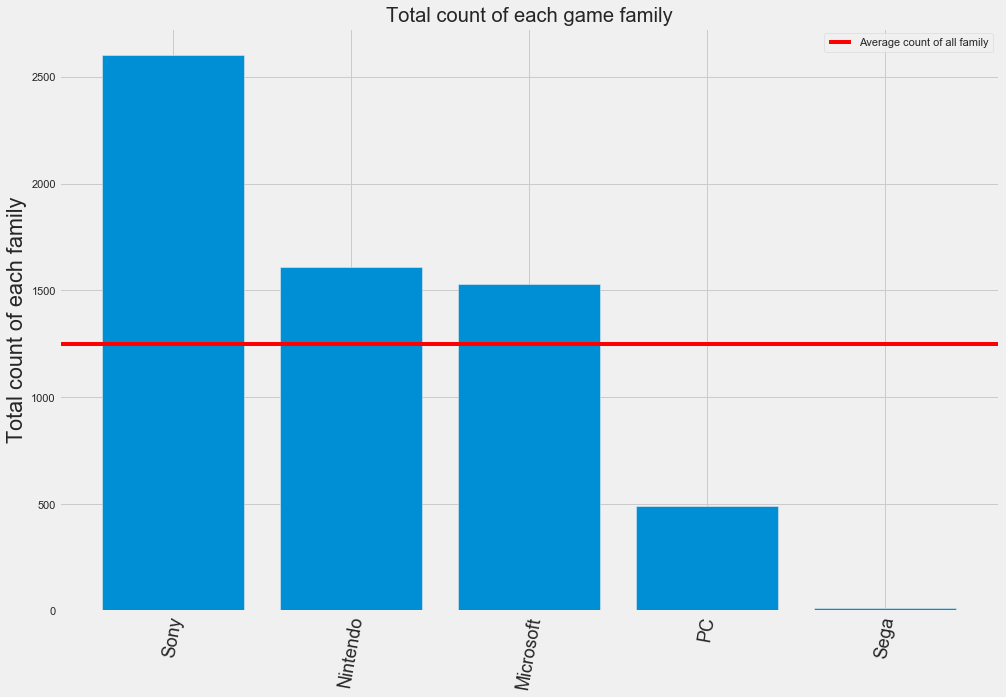

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')


ax.bar(company_df["Family"],company_df["Count"])
ax.axhline(company_df["Count"].mean(), color="red", label="Average count of all family")

ax.set_xticklabels(company_df["Family"], rotation=80, fontsize=18)

ax.set_ylabel("Total count of each family")
ax.set_title('Total count of each game family')
ax.legend()

plt.show()

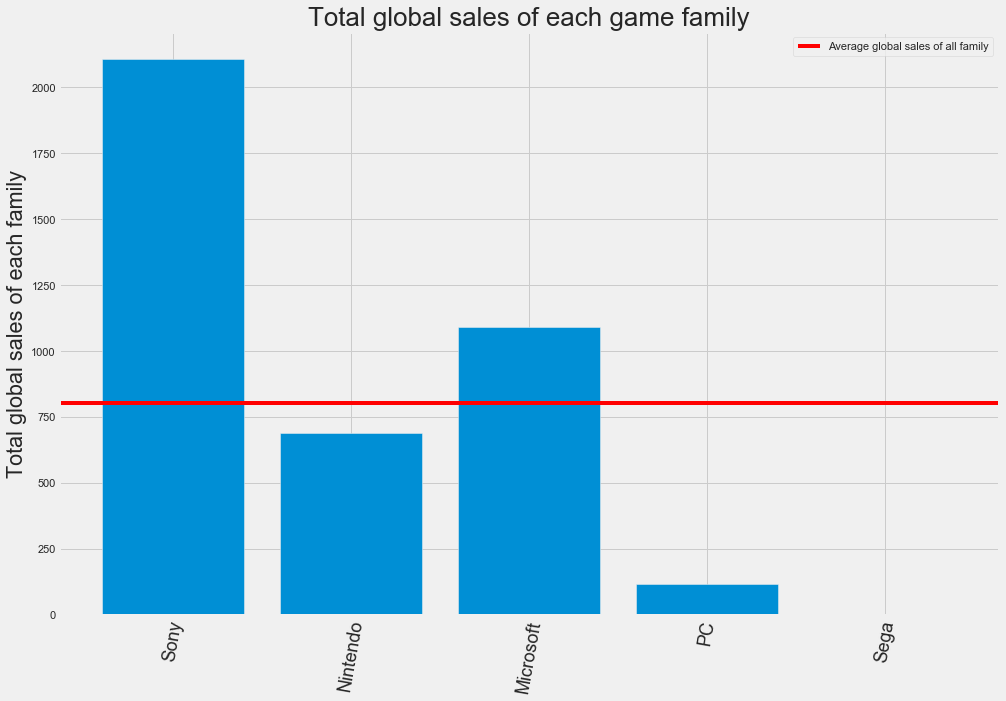

In [52]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(company_df["Family"],company_df["Sum"])
ax.axhline(company_df["Sum"].mean(), color="red", label="Average global sales of all family")

ax.set_xticklabels(company_df["Family"], rotation=80, fontsize=18)

ax.set_ylabel("Total global sales of each family")
ax.set_title('Total global sales of each game family')
ax.legend()

plt.show()

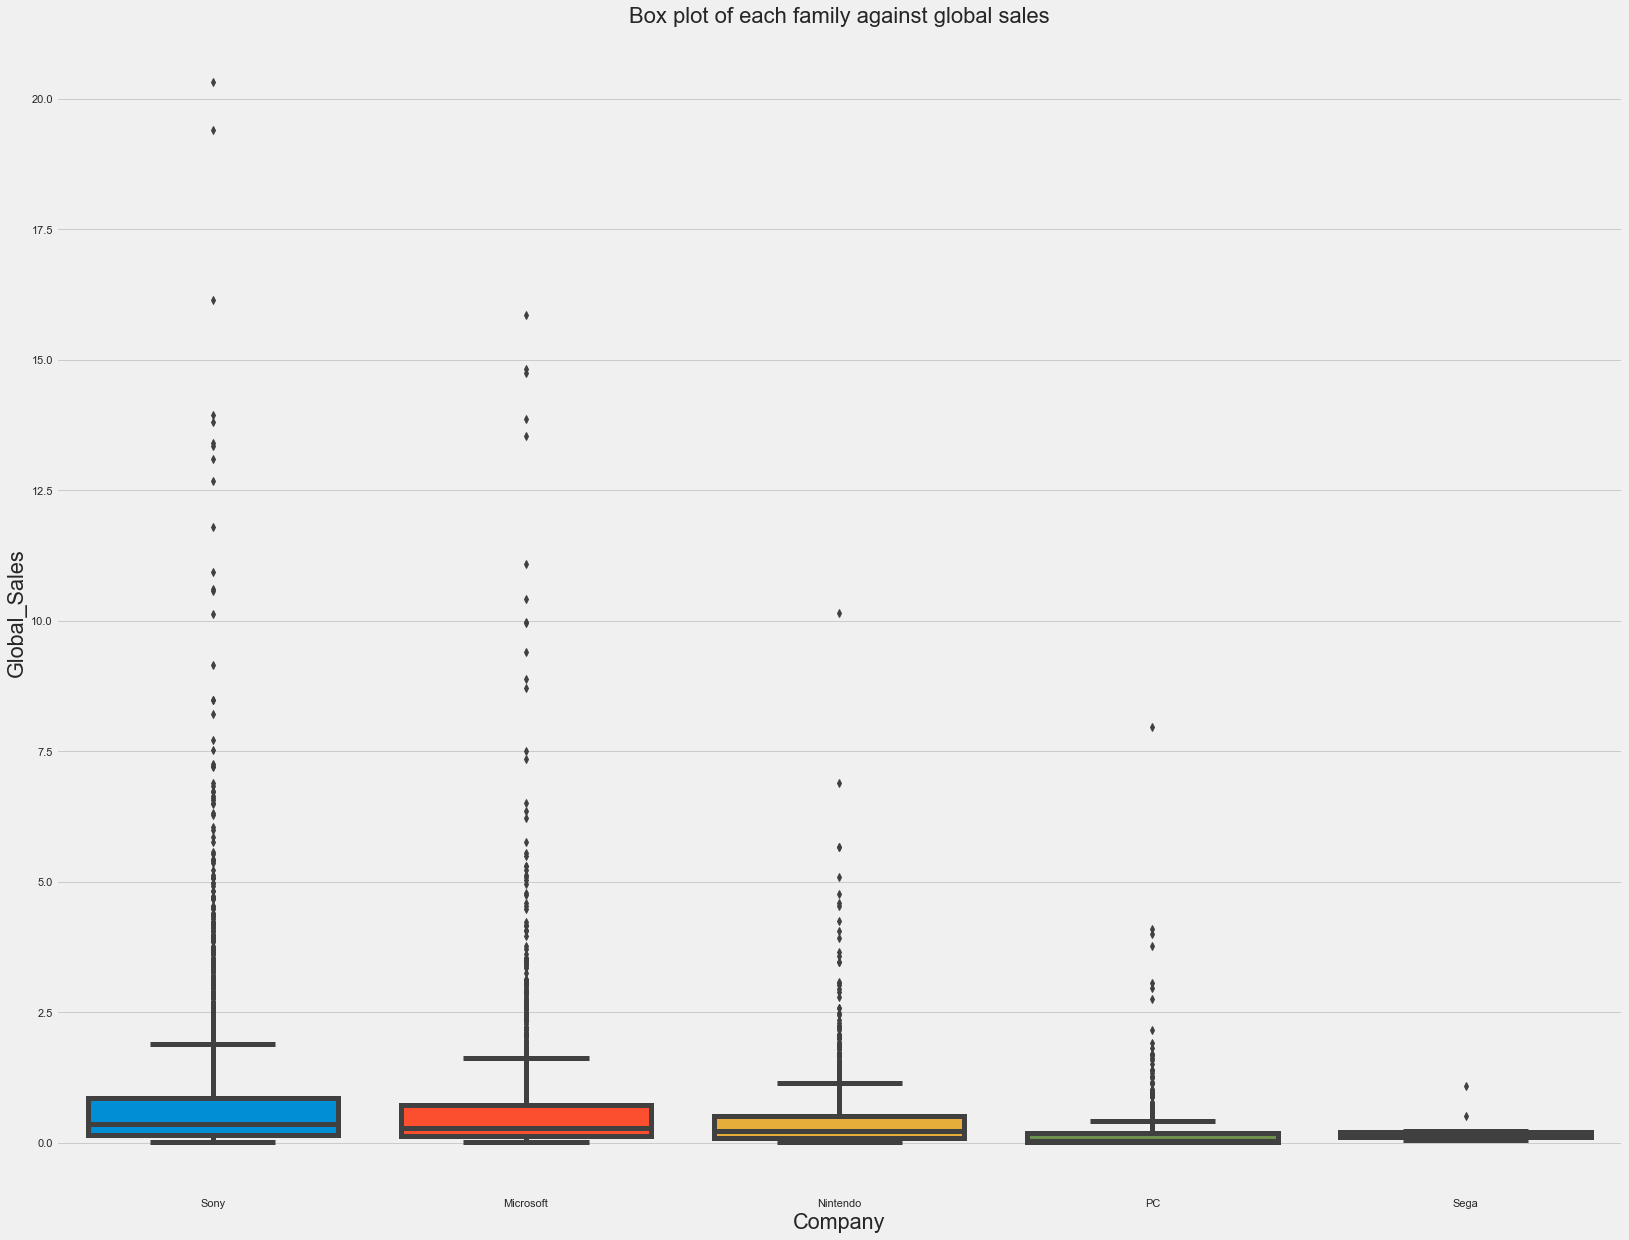

In [53]:
fig, ax = plt.subplots(figsize=(25,20))
plt.rcParams.update({'font.size': 18})

ax = sns.boxplot(x=df['Company'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each family against global sales', fontsize= 22)
ax

### Video Game Publishers

In [54]:
publisher_df = df.groupby('Publisher', as_index=False).agg({'Global_Sales': ['sum','count']})
publisher_df.columns = publisher_df.columns.droplevel(0)
publisher_df.reset_index()

,index,,sum,count
0,0,2K Games,47.87,77
1,1,2K Sports,76.90,94
2,2,505 Games,16.04,47
3,3,Acclaim Entertainment,20.92,68
4,4,Activision,472.65,412
5,5,Agetec,4.84,25
6,6,Aksys Games,4.54,32
7,7,Atari,45.95,125
8,8,Atlus,29.63,131
9,9,Bethesda Softworks,94.00,67


In [55]:
publisher_df.describe()

,sum,count
count,48.000000,48.000000
mean,83.518125,130.041667
std,112.222540,158.315999
min,4.020000,25.000000
25%,16.925000,47.750000
50%,41.190000,69.000000
75%,85.967500,126.500000
max,472.650000,922.000000


In [56]:
publisher_df.columns = ['Publisher', 'Sum', 'Count']
publisher_df = publisher_df.sort_values("Count", ascending=False)
publisher_df

,Publisher,Sum,Count
32,Others,273.43,922
18,Electronic Arts,441.27,459
4,Activision,472.65,412
43,Ubisoft,277.49,393
15,EA Sports,362.24,342
34,Sega,126.52,274
40,THQ,138.91,243
36,Sony Computer Entertainment,232.08,242
10,Capcom,95.85,206
20,Konami,111.34,206


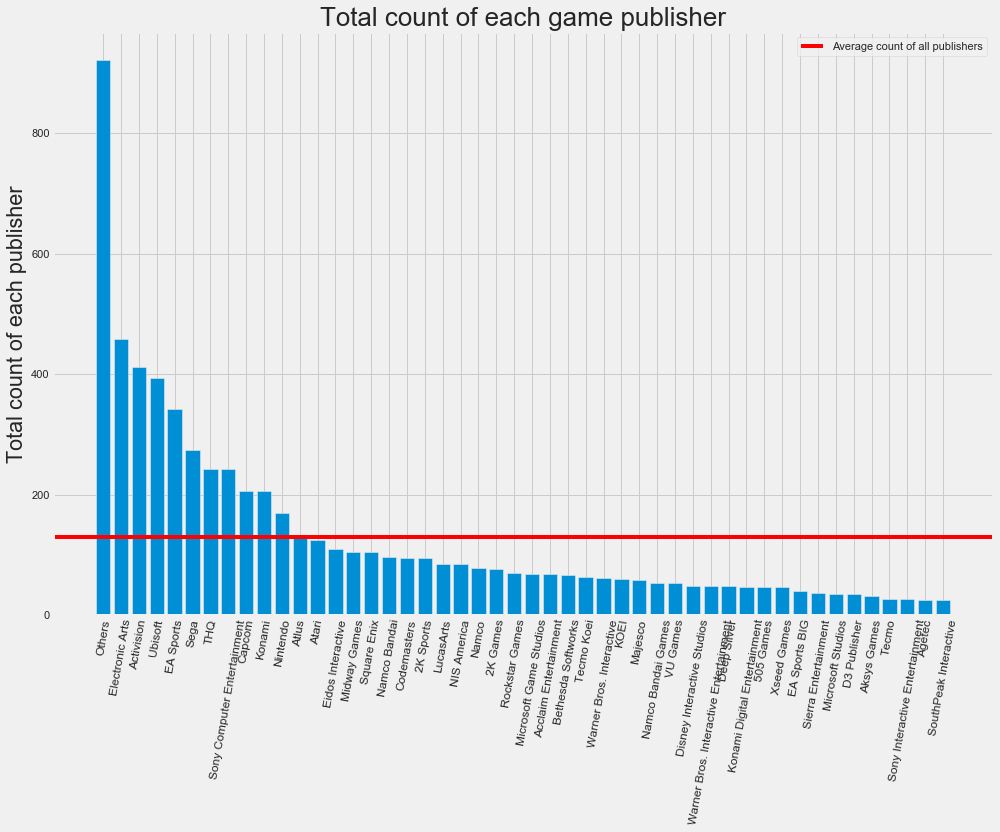

In [57]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(publisher_df["Publisher"],publisher_df["Count"])
ax.axhline(publisher_df["Count"].mean(), color="red", label="Average count of all publishers")

ax.set_xticklabels(publisher_df["Publisher"], rotation=80, fontsize=12)

ax.set_ylabel("Total count of each publisher")
ax.set_title('Total count of each game publisher')
ax.legend()

plt.show()

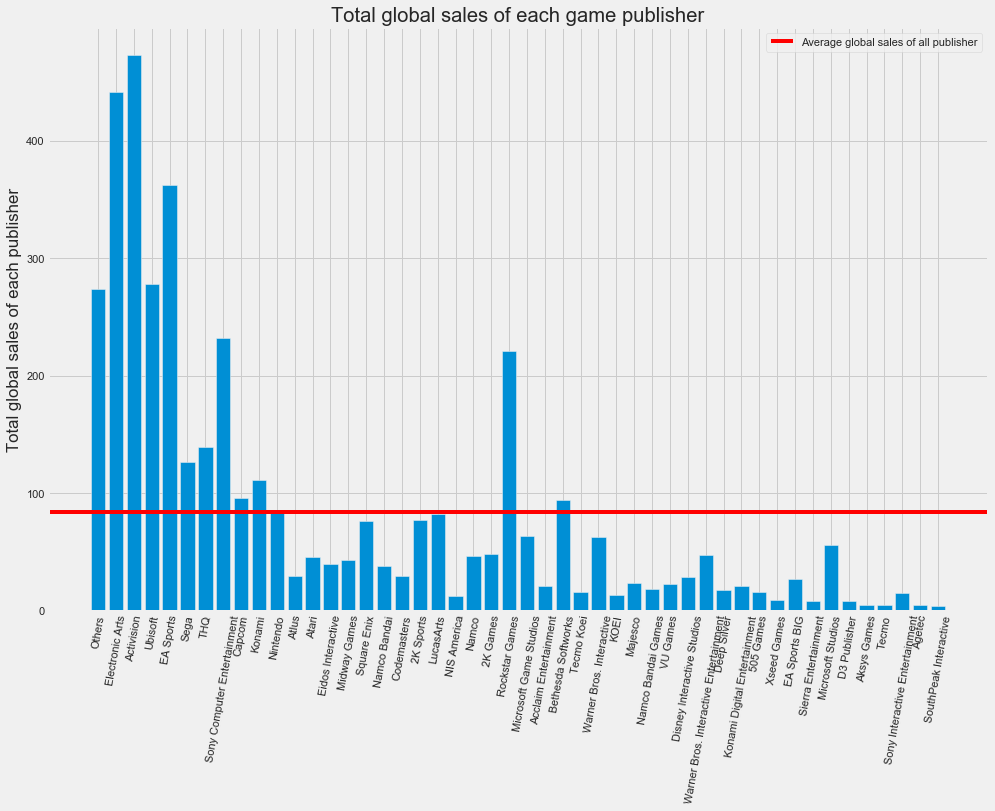

In [58]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(publisher_df["Publisher"],publisher_df["Sum"])
ax.axhline(publisher_df["Sum"].mean(), color="red", label="Average global sales of all publisher")

ax.set_xticklabels(publisher_df["Publisher"], rotation=80)

ax.set_ylabel("Total global sales of each publisher")
ax.set_title('Total global sales of each game publisher')
ax.legend()

plt.show()

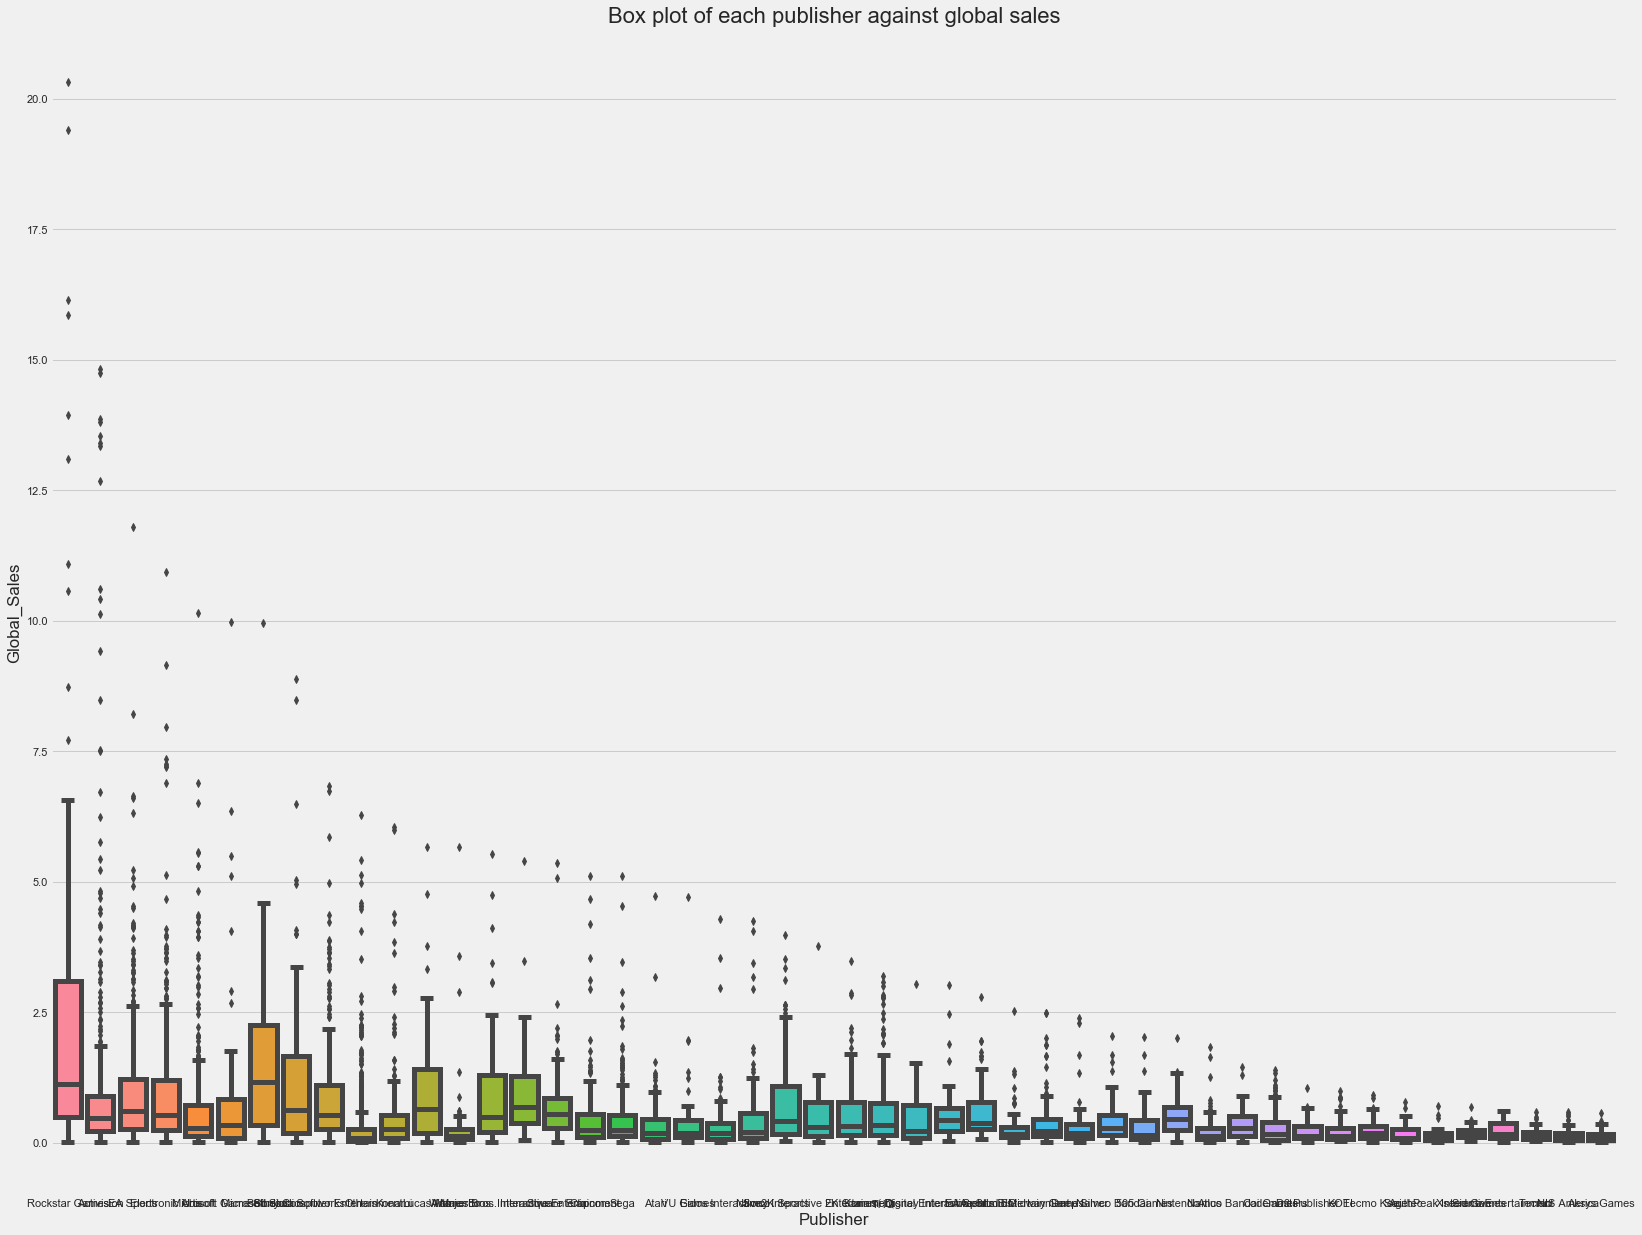

In [59]:
fig, ax = plt.subplots(figsize=(25,20))
ax = sns.boxplot(x=df['Publisher'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each publisher against global sales', fontsize= 22)
ax

### ESB Ratings

In [60]:
rating_df = df.groupby('ESRB_Rating', as_index=False).agg({'Global_Sales': ['sum','count']})
rating_df.columns = rating_df.columns.droplevel(0)
rating_df.reset_index()
rating_df

,,sum,count
0,E,1177.01,1826
1,E10,412.23,822
2,M,1321.90,1366
3,RP,4.12,12
4,T,1093.61,2216


In [61]:
rating_df.columns = ['Rating', 'Sum', 'Count']
rating_df = rating_df.sort_values("Count", ascending=False)
rating_df

,Rating,Sum,Count
4,T,1093.61,2216
0,E,1177.01,1826
2,M,1321.90,1366
1,E10,412.23,822
3,RP,4.12,12


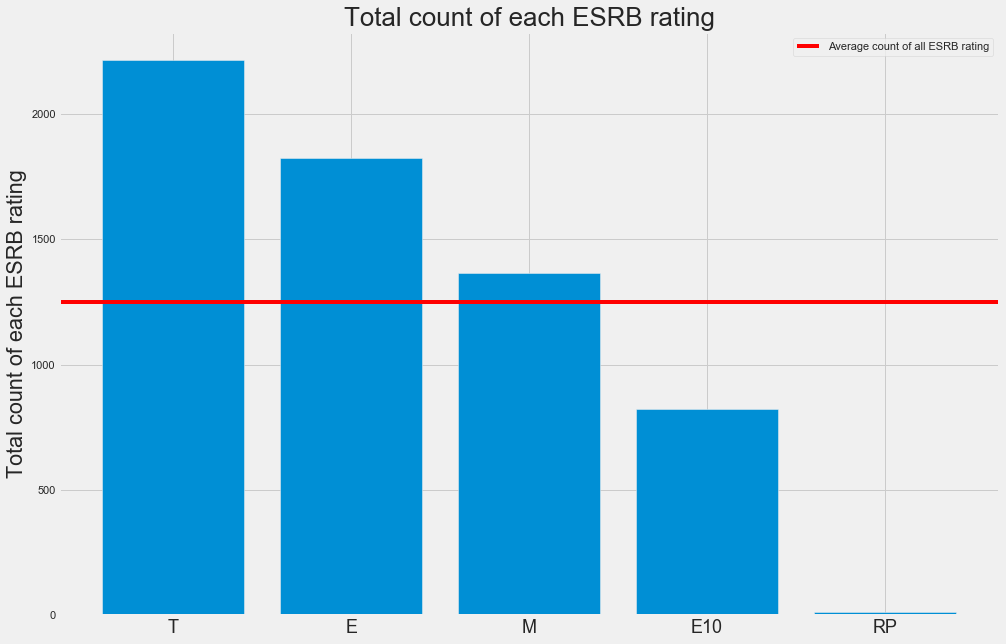

In [62]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(rating_df["Rating"],rating_df["Count"])
ax.axhline(rating_df["Count"].mean(), color="red", label="Average count of all ESRB rating")

ax.set_xticklabels(rating_df["Rating"], rotation=0, fontsize=18)

ax.set_ylabel("Total count of each ESRB rating")
ax.set_title('Total count of each ESRB rating')
ax.legend()

plt.show()

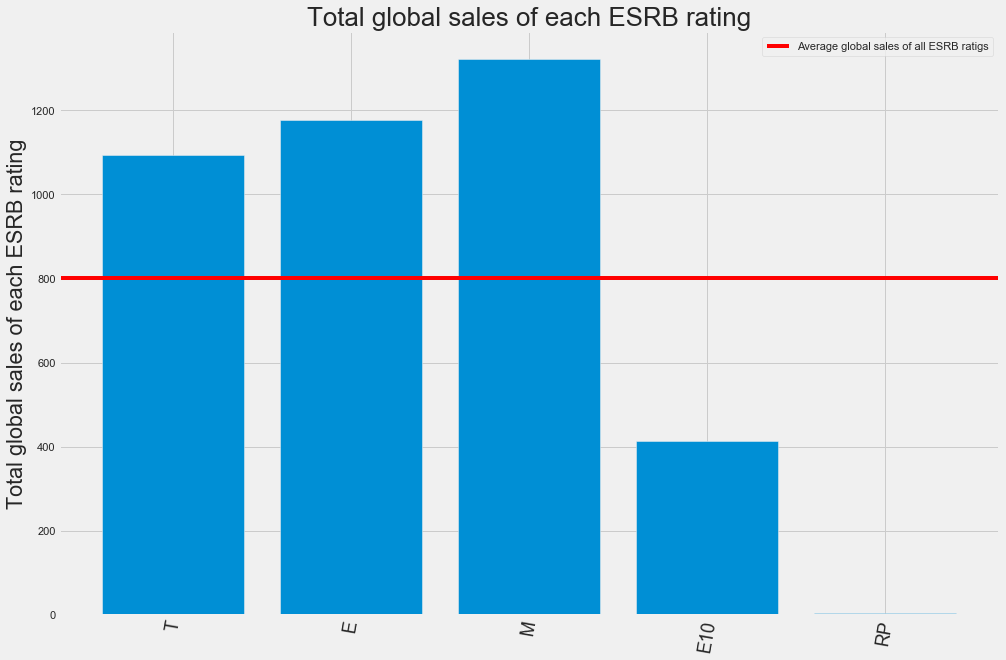

In [63]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(rating_df["Rating"],rating_df["Sum"])
ax.axhline(rating_df["Sum"].mean(), color="red", label="Average global sales of all ESRB ratigs")

ax.set_xticklabels(rating_df["Rating"], rotation=80, fontsize=18)

ax.set_ylabel("Total global sales of each ESRB rating")
ax.set_title('Total global sales of each ESRB rating')
ax.legend()

plt.show()

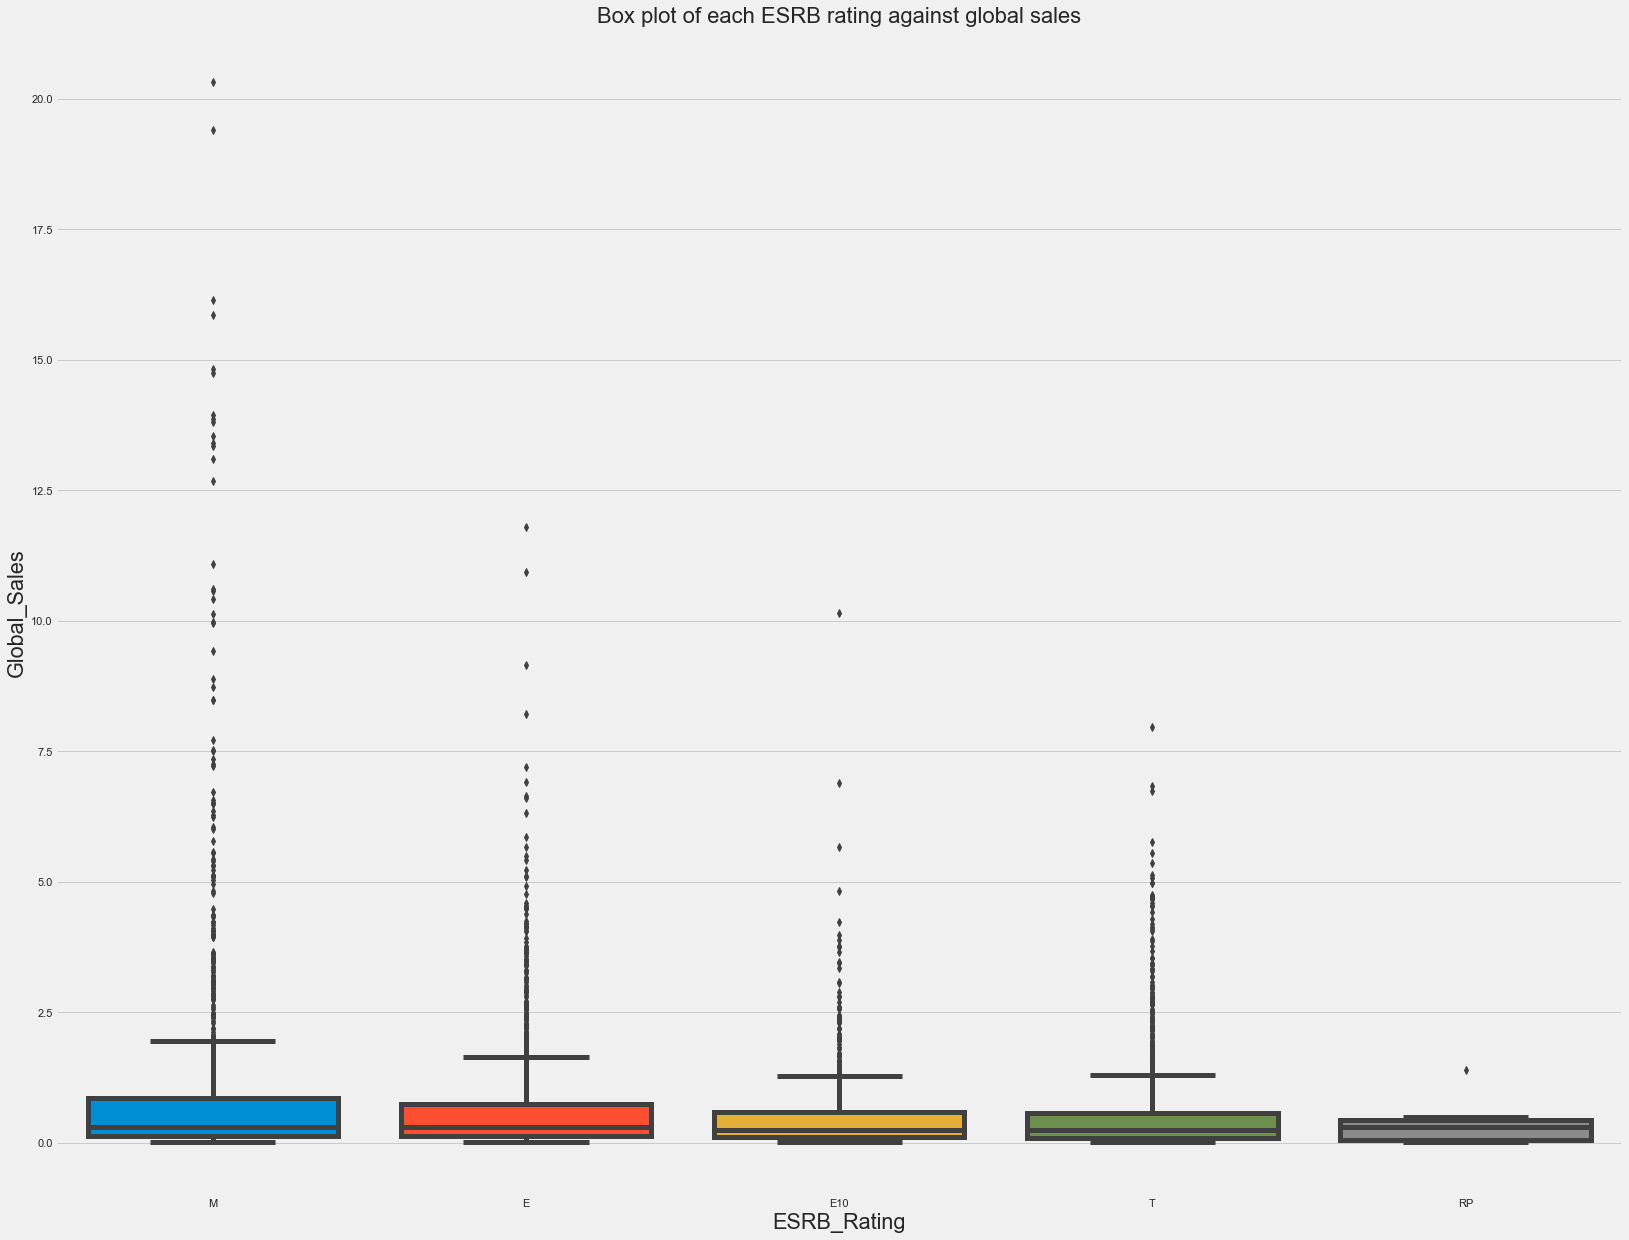

In [64]:
fig, ax = plt.subplots(figsize=(25,20))
plt.rcParams.update({'font.size': 18})

ax = sns.boxplot(x=df['ESRB_Rating'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each ESRB rating against global sales', fontsize= 22)
ax

## Hypothesis Testing (alpha = 0.05)

### Null Hypothesis: Equal distribution of global sales across all genres
### Alternate Hypothesis: Not equal distribution of global sales across all genres

In [65]:
expected = genre_df['Sum'].sum() / genre_df.shape[0]
expected_array = np.full((genre_df.shape[0],), expected)

In [66]:
scipy.stats.chisquare(genre_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=3119.9690793914415, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game genres.

### Null Hypothesis: Equal distribution of global sales across all platforms
### Alternate Hypothesis: Not equal distribution of global sales across all platforms

In [67]:
expected = platform_df['Sum'].sum() / platform_df.shape[0]
expected_array = np.full((platform_df.shape[0],), expected)

In [68]:
scipy.stats.chisquare(platform_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=5356.762379822746, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game platforms.

### Null Hypothesis: Equal distribution of global sales across all video game family
### Alternate Hypothesis: Not equal distribution of global sales across all video game family

In [69]:
expected = company_df['Sum'].sum() / company_df.shape[0]
expected_array = np.full((company_df.shape[0],), expected)

In [70]:
scipy.stats.chisquare(company_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=3616.6226242308617, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game platforms.

### Null Hypothesis: Equal distribution of global sales across all video game ESRB ratings
### Alternate Hypothesis: Not equal distribution of global sales across all video game ESRB ratings

In [71]:
expected = rating_df['Sum'].sum() / rating_df.shape[0]
expected_array = np.full((company_df.shape[0],), expected)

In [72]:
scipy.stats.chisquare(rating_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=1602.069653194023, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game platforms.

### Null Hypothesis: Equal distribution of global sales across all years
### Alternate Hypothesis: Not equal distribution of global sales across all years

In [73]:
year_df = df.groupby('Year', as_index=False).agg({'Global_Sales': ['sum','count']})
year_df.columns = year_df.columns.droplevel(0)
year_df.reset_index()

,index,,sum,count
0,0,1996,1.03,1
1,1,2000,76.67,100
2,2,2001,171.90,226
3,3,2002,229.10,397
4,4,2003,231.99,473
5,5,2004,213.00,417
6,6,2005,213.49,540
7,7,2006,188.25,430
8,8,2007,300.52,514
9,9,2008,350.50,513


In [74]:
year_df.columns = ['Year', 'Sum', 'Count']
year_df = year_df.sort_values("Count", ascending=False)

In [75]:
year_df

,Year,Sum,Count
6,2005,213.49,540
8,2007,300.52,514
9,2008,350.50,513
10,2009,323.68,485
4,2003,231.99,473
7,2006,188.25,430
5,2004,213.00,417
12,2011,348.36,399
3,2002,229.10,397
11,2010,303.49,396


In [76]:
expected = year_df['Sum'].sum() / year_df.shape[0]
expected_array = np.full((year_df.shape[0],), expected)

In [77]:
scipy.stats.chisquare(year_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=1300.2965543158016, pvalue=2.0885981530789304e-262)

Because the pvalue is greateer than alpha, we fail to reject the hypothesis that there is equal distribution of global sales across all years. It can be said that the market of video games is quite consistent over the past years.

### Null Hypothesis: Equal distribution of global sales across all publishers
### Alternate Hypothesis: Not equal distribution of global sales across all publishers

In [78]:
publisher_df = df.groupby('Publisher', as_index=False).agg({'Global_Sales': ['sum','count']})
publisher_df.columns = publisher_df.columns.droplevel(0)
publisher_df.reset_index()

,index,,sum,count
0,0,2K Games,47.87,77
1,1,2K Sports,76.90,94
2,2,505 Games,16.04,47
3,3,Acclaim Entertainment,20.92,68
4,4,Activision,472.65,412
5,5,Agetec,4.84,25
6,6,Aksys Games,4.54,32
7,7,Atari,45.95,125
8,8,Atlus,29.63,131
9,9,Bethesda Softworks,94.00,67


In [79]:
publisher_df.columns = ['Publisher', 'Sum', 'Count']
publisher_df = publisher_df.sort_values("Count", ascending=False)

In [80]:
publisher_df

,Publisher,Sum,Count
32,Others,273.43,922
18,Electronic Arts,441.27,459
4,Activision,472.65,412
43,Ubisoft,277.49,393
15,EA Sports,362.24,342
34,Sega,126.52,274
40,THQ,138.91,243
36,Sony Computer Entertainment,232.08,242
10,Capcom,95.85,206
20,Konami,111.34,206


In [81]:
expected = publisher_df['Sum'].sum() / publisher_df.shape[0]
expected_array = np.full((publisher_df.shape[0],), expected)

In [82]:
scipy.stats.chisquare(publisher_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=7087.24279348044, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game publishers.